In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from torchvision import transforms as pth_transforms
import torch
from PIL import Image
import matplotlib.pyplot as plt

from helpers import power_method, prep_for_power_method, HookAttention

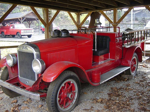

In [3]:
img_file = 'assets/n03345487_fire_engine.JPEG'
img = Image.open(img_file).convert('RGB')
W, H = img.size
display(img.resize((150,150*H//W)))

# Demo for DINOv1

In [24]:
import dino

In [25]:
image_size = 240
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [ ]:
# Load model
device = "cuda:0"
arch = 'vit_small'
patch_size = 8
model = dino.__dict__[arch](patch_size=patch_size)
model.eval()
model = model.to(device)
dino.load_pretrained_vit_weights(model, arch, patch_size=patch_size)
# replace with custom attention for forward hooking
model = dino.replace_attn(model)

Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


In [ ]:
# Extract attention
model_with_hooks = HookAttention(model)

with torch.no_grad():
    o = model.forward(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions).cpu() # (n_layers, b, h, seq, seq)
print(attentions.shape)

torch.Size([12, 1, 6, 901, 901])


In [ ]:
# Power iteration: Propagating of attention
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1)
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=100, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")

Performed 14 iterations of power method


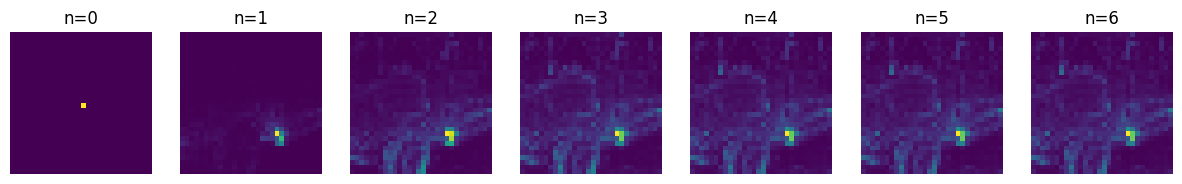

In [29]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")

## Computation of eigenvalues

In [33]:
tmp = prep_for_power_method(my_att)
vals, _ = torch.linalg.eigvals(tmp).abs().topk(2, dim=-1)
vals = vals.cpu().numpy()
print(f"Eigenvalues: {vals}")

Eigenvalues: [1.0000005 0.4471389]


# Demo for DINOv2

Requires DINOv2 repository. For this run
```
git clone https://github.com/facebookresearch/dinov2.git ..dinov2
```

In [ ]:
import dino_v2

In [ ]:
# Load model
device = "cuda:0"
arch = 'vit_small'
model = dino_v2.load_pretrained(arch)
model.eval()
model = model.to(device)
# replace with custom attention for forward hooking
model = dino_v2.replace_attn(model)

Loading DINOv2 model with backbone: dinov2_vits14_reg


Using cache found in ./models/dinov2/facebookresearch_dinov2_main


In [13]:
image_size = 700
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [ ]:
# Extract attention
model_with_hooks = HookAttention(model)
with torch.no_grad():
    o = model.forward(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions).cpu() # (n_layers, b, h, seq, seq)
print(attentions.shape)

torch.Size([12, 1, 6, 2505, 2505])


In [ ]:
# Power iteration: Propagating of attention
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1) # Skip [CLS] token
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=100, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")
intermeds = intermeds[:,model.num_register_tokens:]

Performed 38 iterations of power method


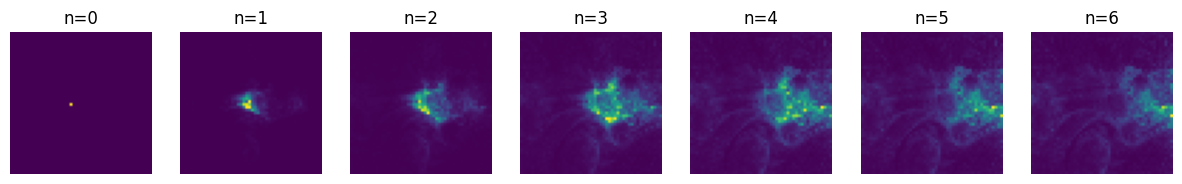

In [17]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")

# Demo for ViT (transformers)

In [ ]:
from transformers import ViTForImageClassification
import vit

In [ ]:
device = "cuda:0"
arch = 'vit-base'
patch_size = 16

model = ViTForImageClassification.from_pretrained(f'google/{arch}-patch{patch_size}-224', cache_dir="./models")
model.eval()
model = model.to(device)
configuration = model.config
# replace with custom attention for forward hooking
model = vit.replace_attn(model, configuration)

In [20]:
image_size = 224
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [21]:
# Extract attention
model_with_hooks = HookAttention(model)
with torch.no_grad():
    o = model.forward(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions).cpu() # (n_layers, b, h, seq, seq)
print(attentions.shape)


torch.Size([12, 1, 12, 197, 197])


In [ ]:
# Power iteration: Propagating of attention
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1)
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=100, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")

Performed 18 iterations of power method


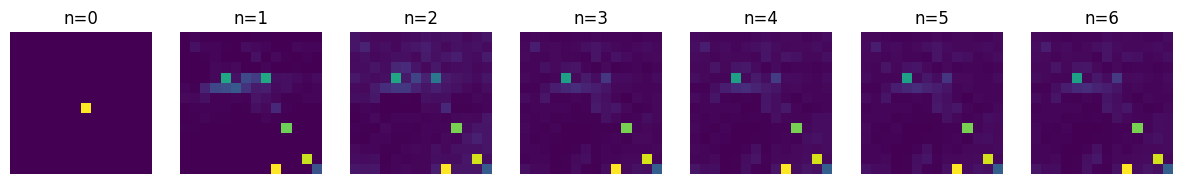

In [23]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")

# Demo for CLIP

In [35]:
from transformers import CLIPProcessor, CLIPModel
import clip

In [ ]:
device = 'cuda:0'
arch = "vit-base"
patch_size = 16

model_id = f"openai/clip-{arch}-patch{patch_size}"
processor = CLIPProcessor.from_pretrained(model_id, cache_dir="./models")
model = CLIPModel.from_pretrained(model_id, cache_dir="./models")
model.eval()
model = model.to(device)
model.vision_model = clip.replace_attn(model.vision_model)

In [40]:
image_size = 224
transform = pth_transforms.Compose([
        pth_transforms.Resize(int(image_size*256/224)),
        pth_transforms.CenterCrop(image_size),
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img_t = transform(img)

In [ ]:
# Extract attention
model_with_hooks = HookAttention(model)
with torch.no_grad():
    img_emb = model.get_image_features(img_t.to(device).unsqueeze(0))

model_with_hooks.remove_hooks()
attentions = torch.stack(model_with_hooks.attentions).cpu() # (n_layers, b, h, seq, seq)
print(attentions.shape)


torch.Size([12, 1, 12, 197, 197])


In [42]:
# Power iteration: Propagating of attention
L = 8
H = 1
attention = attentions[L,0,H]
my_att = torch.softmax(attention[...,1:,1:], dim=-1)
N=int(my_att.shape[-1]**0.5)
init_state = torch.zeros(my_att.shape[-1]); init_state[N**2//2+N//2] = 1.0
T = prep_for_power_method(my_att)
att_bounced_p, intermeds = power_method(T, init_state, max_iter=100, return_intermed=True)
print(f"Performed {len(intermeds)} iterations of power method")

Performed 53 iterations of power method


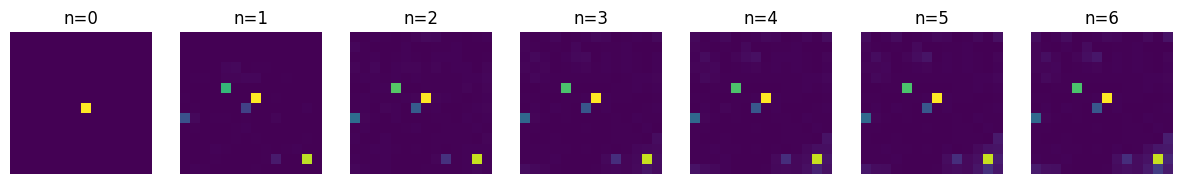

In [43]:
# Visualization
plt.figure(figsize=(15,3))
for i in range(7):
    plt.subplot(1,7, i+1)
    plt.imshow(intermeds[i].reshape(N,N)); plt.axis('off')
    plt.title(f"n={i}")